# p2 - Underground Commuters 


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
#we are going to read the tube network from the shape file
#first, check current directory
os.getcwd()

'/Users/yingchen/Documents2/CASA/urban_simulation/practical/wk7/Week_7_final'

In [3]:
# You need to set the working directory to where you have your shapefile data
os.chdir('underground')

# Let's create a graph from the shapefile
g_shp=nx.read_shp('underground.shp',geom_attrs=False)

In [4]:
#we will need to add station names as attributes of the nodes:
nod_st1={(e1):weight for e1, e2, weight in g_shp.edges(data='station_1_')}
nod_st2={(e2):weight for e1, e2, weight in g_shp.edges(data='station_2_')}
#nod_all = {**nod_st1, **nod_st2} #for python 3.5 and greater

#In Python 2, (or 3.4 or lower) write a function
nod_all = nod_st1.copy()   # start with x's keys and values
nod_all.update(nod_st2)

nx.set_node_attributes(g_shp,nod_all,'station')

# get the nodes attributes:
#list(g_shp.nodes(data=True))[0:10]

In [5]:
#do we want this graph to be a directed one? In fact, only a few links in the dataset are directed

# We can transform the type of graph from directed to undirected using the following function:
g_shp_un = g_shp.to_undirected()

#Finally, we will give an ID to each node(station), such that it will be easier later to call them:
#1.Create a new attribute with node coordinates (now coord are the keys and we do not want to lose that information
nod_coord = {(e1):e1 for e1 in g_shp_un.nodes()}
nx.set_node_attributes(g_shp_un,nod_coord,'station_coord')
list(g_shp_un.nodes(data=True))[0]


((-0.1571, 51.5226),
 {'station': 'Baker Street', 'station_coord': (-0.1571, 51.5226)})

In [6]:
#2.now relabel each node with an ordered integer:
node_list = list(g_shp_un.nodes())
mapping = {node_list[i]:i for i in range(len(node_list))}
g_shp_un = nx.relabel_nodes(g_shp_un, mapping)
list(g_shp_un.nodes(data=True))[0]

(0, {'station': 'Baker Street', 'station_coord': (-0.1571, 51.5226)})

In [7]:
#Later when using the Commuters data we will have an issue mapping node 'Heathrow Terminals 1, 2 & 3', 
#so we are going to rename it here:
#1. find the node 'Heathrow Terminals 1, 2 & 3'
nodes = [(x,y) for x,y in g_shp_un.nodes(data='station') if 'Heathrow' in str(y)]
nodes

[(258, 'Heathrow Terminals 1, 2 & 3'), (259, 'Heathrow Terminal 4')]

In [8]:
#2.Rename it with the name given by the the commuters file (see later):
g_shp_un.nodes[258]['station']='Heathrow Terminals 123'

## Commuters flows in the tube network

We are going to create the flows of commuters travelling between any pair of tube stations

In [9]:
import pandas as pd
#First, we read the csv file with commuting flows starting and ending between stations, called Origin-Destination:
#Check you are in the correct directory to read the csv 
os.getcwd()

'/Users/yingchen/Documents2/CASA/urban_simulation/practical/wk7/Week_7_final/underground'

In [10]:
os.chdir('..')
os.getcwd()

'/Users/yingchen/Documents2/CASA/urban_simulation/practical/wk7/Week_7_final'

In [11]:
# Read Origin-Destination table from the csv
orig_dest = pd.read_csv('ODtube2017.csv')
orig_dest.head()

,From,station_name,To,station_name.1,total_wtrips
0,500,Acton Town,505,Alperton,143
1,500,Acton Town,506,Amersham,22
2,500,Acton Town,507,Angel,15
3,500,Acton Town,508,Archway,9
4,500,Acton Town,510,Arsenal,9


In [12]:
#This can be seen as a network by itself:
g_OD = nx.from_pandas_edgelist(orig_dest, 'station_name', 'station_name.1',['total_wtrips'],create_using=nx.MultiDiGraph)

In [13]:
#Change the names of nodes by the id in g_shp_un (tube network):

#1.Copy name as an attribute:
nod_names={(e1):e1 for e1 in g_OD.nodes()}
nx.set_node_attributes(g_OD,nod_names,'station') #with nod_id1 or nod_id2 is enought
print(list(g_OD.nodes(data=True))[:10])

[('Acton Town', {'station': 'Acton Town'}), ('Alperton', {'station': 'Alperton'}), ('Amersham', {'station': 'Amersham'}), ('Angel', {'station': 'Angel'}), ('Archway', {'station': 'Archway'}), ('Arsenal', {'station': 'Arsenal'}), ('Baker Street', {'station': 'Baker Street'}), ('Bank', {'station': 'Bank'}), ('Barbican', {'station': 'Barbican'}), ('Barons Court', {'station': 'Barons Court'})]


In [14]:
#2.Do the mapping with id in g_shp_un
mapping = {g_shp_un.nodes[i]['station']:i for i in g_shp_un.nodes()}
g_OD = nx.relabel_nodes(g_OD, mapping)
print(list(g_OD.nodes(data=True))[:10])

[(111, {'station': 'Acton Town'}), (238, {'station': 'Alperton'}), (172, {'station': 'Amersham'}), (196, {'station': 'Angel'}), (198, {'station': 'Archway'}), (244, {'station': 'Arsenal'}), (0, {'station': 'Baker Street'}), (25, {'station': 'Bank'}), (77, {'station': 'Barbican'}), (100, {'station': 'Barons Court'})]


In [15]:
#and we can add coordinates to the nodes, from the shapefile of the tube network:
nod_coords={(e1):coord for e1, coord in g_shp_un.nodes(data='station_coord')}

nx.set_node_attributes(g_OD,nod_coords,'station_coord') #with nod_id1 or nod_id2 is enought

pos = {e1: xy for e1,xy in g_OD.nodes(data='station_coord')}


In [16]:
#Even if we have not considered the weights (we will later on), 
#this network does not represent the commuting flows, what is happening?

#From the Origin Destination network, we need to compute the number of commuters for each pair of stations:
#How will we know the path of commuters from their origin to their destinations? 
#Given that the tube network is undirected and that we do not have information on the different tube lines, 
#we will assume that commuters use the shortest path between Origin and Destination

In [17]:
#Now, let's create the network with the actual flow of commuters travelling between each pair of stations,
#regardless which was their origin and destination:

#We will create that graph using the adjacency matrix method that was presented in previous practicals:
#First we create an empty adjacency matrix:
N=len(g_shp_un.nodes()) #As we are going to use shortest path in the tube network, N is from g_shp_un
adj_c=np.zeros((N, N))

#Fill the adjacency matrix with Origin-Destination flows:
#From origin to destination with x commuters, we will compute the shortest path and fill the number of commuters
#for each pair of stations they go through:
for e1,e2,C in g_OD.edges(data='total_wtrips'):
    path = nx.dijkstra_path(g_shp_un,e1,e2,'distance')  #shortest path e1,e2 taking into account distance weights in g_shp_un
    path_edges = list(zip(path,path[1:])) #list of tuples with shortest path edges [(e1,s2),(s3,s4),...,(s(n-1),e2)]
    for (s1,s2) in path_edges:
            adj_c[s1,s2]=adj_c[s1,s2]+C #sum the contribution of the OD flow to all edges in the shortest path
adj_c

array([[     0.,  96682.,   1560., ...,      0.,      0.,      0.],
       [102485.,      0.,      0., ...,      0.,      0.,      0.],
       [  1167.,      0.,      0., ...,      0.,      0.,      0.],
       ...,
       [     0.,      0.,      0., ...,      0.,  34817.,      0.],
       [     0.,      0.,      0., ...,  37111.,      0.,      0.],
       [     0.,      0.,      0., ...,      0.,      0.,      0.]])

In [18]:
#Create the new graph from the adjancency matrix:
g_flows=nx.from_numpy_matrix(adj_c, create_using=nx.DiGraph)


In [19]:
#we need to give coordinates to these nodes too:
nod_coord = {(e1):coord for e1,coord in g_shp_un.nodes(data='station_coord')}
nx.set_node_attributes(g_flows,nod_coord,'station_coord')
list(g_flows.nodes(data=True))[0:10]

[(0, {'station_coord': (-0.1571, 51.5226)}),
 (1, {'station_coord': (-0.1631, 51.5225)}),
 (2, {'station_coord': (-0.1466, 51.5234)}),
 (3, {'station_coord': (-0.1247, 51.508)}),
 (4, {'station_coord': (-0.1223, 51.5074)}),
 (5, {'station_coord': (-0.1342, 51.5098)}),
 (6, {'station_coord': (-0.1679, 51.5199)}),
 (7, {'station_coord': (-0.1755, 51.5154)}),
 (8, {'station_coord': (-0.1001, 51.4943)}),
 (9, {'station_coord': (-0.1115, 51.4991)})]

In [20]:
#also the station names:
nod_names = {(e1):name for e1,name in g_shp_un.nodes(data='station')}
nx.set_node_attributes(g_flows,nod_names,'station')
list(g_flows.nodes(data=True))[0:10]

[(0, {'station_coord': (-0.1571, 51.5226), 'station': 'Baker Street'}),
 (1, {'station_coord': (-0.1631, 51.5225), 'station': 'Marylebone'}),
 (2, {'station_coord': (-0.1466, 51.5234), 'station': "Regent's Park"}),
 (3, {'station_coord': (-0.1247, 51.508), 'station': 'Charing Cross'}),
 (4, {'station_coord': (-0.1223, 51.5074), 'station': 'Embankment'}),
 (5, {'station_coord': (-0.1342, 51.5098), 'station': 'Picadilly Circus'}),
 (6, {'station_coord': (-0.1679, 51.5199), 'station': 'Edgware Road (B)'}),
 (7, {'station_coord': (-0.1755, 51.5154), 'station': 'Paddington'}),
 (8, {'station_coord': (-0.1001, 51.4943), 'station': 'Elephant & Castle'}),
 (9, {'station_coord': (-0.1115, 51.4991), 'station': 'Lambeth North'})]

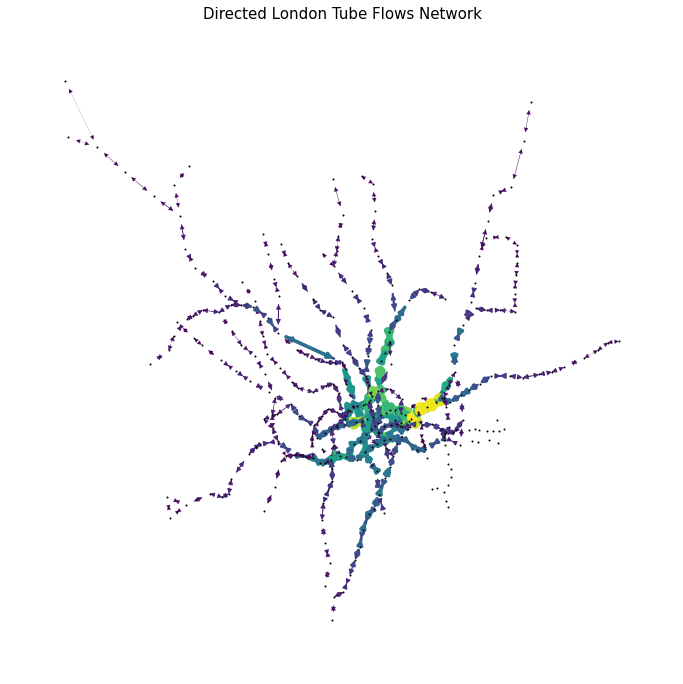

In [21]:
# Lets set colour and size of nodes according to the flows_
weights = [w for e1,e2,w in g_flows.edges(data='weight')]

weights_color=[(w/max(weights)) for e1,e2,w in g_flows.edges(data='weight')]
weights_size=[(w/max(weights)*10) for e1,e2,w in g_flows.edges(data='weight')]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in g_flows.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(g_flows, pos,edge_color=weights_color, width=weights_size)

nx.draw_networkx_nodes(g_flows,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.axis("off")
plt.title("Directed London Tube Flows Network",fontsize=15)
plt.show()

#this are the directed flows in the tube network!

### Search from node/edge

In [22]:
#We can search for nodes in the flow network
#node
node = [(x,y) for x,y in g_flows.nodes(data='station') if y=='Kilburn']
node

[(168, 'Kilburn')]

In [23]:
#or if you do not know how exacly it is written:
node2 = [(x,y) for x,y in g_flows.nodes(data='station') if 'Kil' in str(y)]
print(node2)
g_flows.nodes[19],g_flows.nodes[168] #the IDs may change for Python3/Python2 depending on the order of appearance

[(19, 'Kilburn Park'), (168, 'Kilburn')]


({'station_coord': (-0.1939, 51.5351), 'station': 'Kilburn Park'},
 {'station_coord': (-0.2047, 51.5471), 'station': 'Kilburn'})

In [24]:
#as edges are saved using the IDs, let us create an edges attribute with the station names:
edges_names={(e1,e2):(g_flows.nodes[e1]['station'],g_flows.nodes[e2]['station']) for e1,e2 in g_flows.edges()}

nx.set_edge_attributes(g_flows,edges_names,'station_names') 
print(list(g_flows.edges(data=True))[0])

(0, 1, {'weight': 96682.0, 'station_names': ('Baker Street', 'Marylebone')})


In [25]:
#now, we can search edges by names, as for example all edges comming to and leaving from Kilburn Park:
edge = [(e1,e2) for e1,e2,y in g_flows.edges(data='station_names') if 'Kilburn Park' in str(y)]
print(edge)


[(17, 19), (19, 17), (19, 20), (20, 19)]


In [26]:
g_flows.edges[(17, 19)] #Again, the IDs may change for Python3/Python2 depending on the order of appearance

{'weight': 22009.0, 'station_names': ("Queen's Park", 'Kilburn Park')}

In [27]:
g_flows.edges[(19, 17)] #Again, the IDs may change for Python3/Python2 depending on the order of appearance

{'weight': 14048.0, 'station_names': ('Kilburn Park', "Queen's Park")}

In [28]:
list(g_flows.nodes(data = True))[0:3]

[(0, {'station_coord': (-0.1571, 51.5226), 'station': 'Baker Street'}),
 (1, {'station_coord': (-0.1631, 51.5225), 'station': 'Marylebone'}),
 (2, {'station_coord': (-0.1466, 51.5234), 'station': "Regent's Park"})]

In [29]:
list(g_flows.edges(data = True))[0:3]

[(0, 1, {'weight': 96682.0, 'station_names': ('Baker Street', 'Marylebone')}),
 (0,
  2,
  {'weight': 1560.0, 'station_names': ('Baker Street', "Regent's Park")}),
 (0,
  33,
  {'weight': 126001.0, 'station_names': ('Baker Street', 'Bond Street')})]

## Closeness Centrality

Let's explore the commuting flows network with some exercises on different type of centrality measures and disruptions on the network. Keep in mind that this network is a directed network and nodes and edges centrality depends on the direction of the flows.

In [30]:
# invert commuters
v_weights={(e1, e2):round(1./weight,5) for e1, e2, weight in g_flows.edges(data='weight')}
nx.set_edge_attributes(g_flows, v_weights, 'v_weights')

In [31]:
# centrality for directed commuting flows:
clos_w=nx.closeness_centrality(g_flows, distance='v_weights')
# We can add these values to the nodes attributes:
nx.set_node_attributes(g_flows,clos_w,'clos_flows')

In [32]:
# top 10 nodes with highest centrality values
dict_clos_flows=dict(g_flows.nodes(data=True))
from collections import OrderedDict
listclos_flows=OrderedDict(sorted(dict_clos_flows.items(), key=lambda x: x[1]['clos_flows'],reverse=True))
list(listclos_flows.items())[:10]

[(24,
  {'station_coord': (-0.1415, 51.515),
   'station': 'Oxford Circus',
   'clos_flows': 3314.9359837037646}),
 (155,
  {'station_coord': (-0.1428, 51.5067),
   'station': 'Green Park',
   'clos_flows': 3279.0731465495132}),
 (33,
  {'station_coord': (-0.1494, 51.5142),
   'station': 'Bond Street',
   'clos_flows': 3267.1492441984255}),
 (5,
  {'station_coord': (-0.1342, 51.5098),
   'station': 'Picadilly Circus',
   'clos_flows': 3266.3008543661217}),
 (58,
  {'station_coord': (-0.131, 51.5165),
   'station': 'Tottenham Court Road',
   'clos_flows': 3260.7970421682257}),
 (228,
  {'station_coord': (-0.1384, 51.5247),
   'station': 'Warren Street',
   'clos_flows': 3258.26307218338}),
 (88,
  {'station_coord': (-0.1238, 51.5308),
   'station': "King's Cross St. Pancras",
   'clos_flows': 3258.2630721833775}),
 (93,
  {'station_coord': (-0.1447, 51.4965),
   'station': 'Victoria',
   'clos_flows': 3258.2630721833775}),
 (0,
  {'station_coord': (-0.1571, 51.5226),
   'station': 'Bake

In [33]:
# just the station names
CC=pd.DataFrame.from_dict(clos_w,columns=['clos_flows'],orient='index')
maxclos10=CC.sort_values(by=['clos_flows'],ascending=False)[:10]
maxclos10 = maxclos10.index.tolist()
for i in maxclos10:
    print(g_flows.nodes[i]['station'])

Oxford Circus
Green Park
Bond Street
Picadilly Circus
Tottenham Court Road
Warren Street
King's Cross St. Pancras
Victoria
Baker Street
Euston


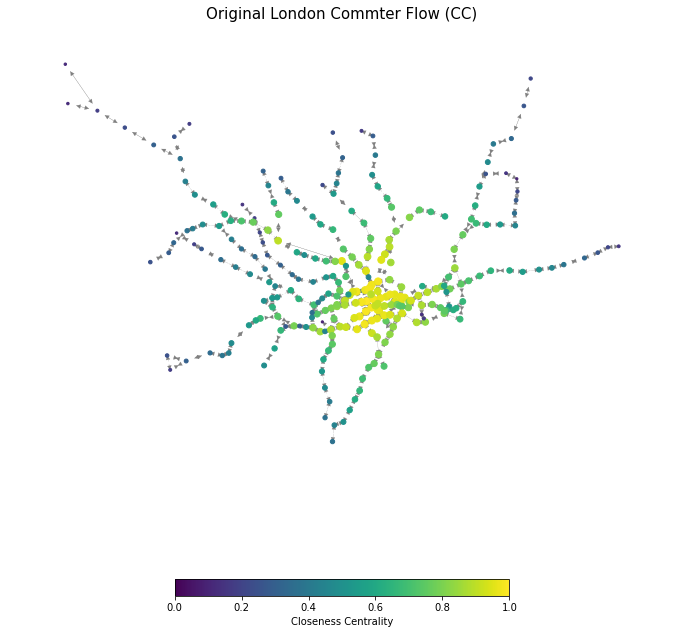

<Figure size 432x288 with 0 Axes>

In [34]:
# 1. Plot directed original graph by edges
clos_w_val=[(i[1]['clos_flows']) for i in g_flows.nodes(data=True)]

clos_w_color=[(i[1]['clos_flows']/max(clos_w_val)) for i in g_flows.nodes(data=True)]
clos_w_size=[(i[1]['clos_flows']/max(clos_w_val)*50) for i in g_flows.nodes(data=True)]

pos={e1: xy for e1,xy in g_flows.nodes(data='station_coord')}

fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in g_shp_un.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(g_flows, pos,edge_color='gray', width=0.2)

nod=nx.draw_networkx_nodes(g_flows,
        pos = pos,
        node_color= clos_w_color,
        node_size= clos_w_size)

plt.axis("off")
plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Original London Commter Flow (CC)",fontsize=15)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('p2_CC1.png', dpi=100)

### Sequential removal

In [35]:
nodes=[]
for i in range (10):
    a = nx.get_node_attributes(g_flows,'clos_flows')
    for n in g_flows:
        if a[n] == max(clos_w.values()):
            print(g_flows.nodes[n]['station'])
            nodes.append(n)
            g_flows.remove_node(n)
            clos_w=nx.closeness_centrality(g_flows, distance='v_weights')
            nx.set_node_attributes(g_flows,clos_w,'clos_flows')
            break
print(nodes)

Oxford Circus
Baker Street
Waterloo
Green Park
Victoria
Bank
Mile End
Whitechapel
King's Cross St. Pancras
Tottenham Court Road
[24, 0, 10, 155, 93, 25, 32, 96, 88, 58]


In [36]:
print(nx.info(g_flows))

Name: 
Type: DiGraph
Number of nodes: 296
Number of edges: 553
Average in degree:   1.8682
Average out degree:   1.8682


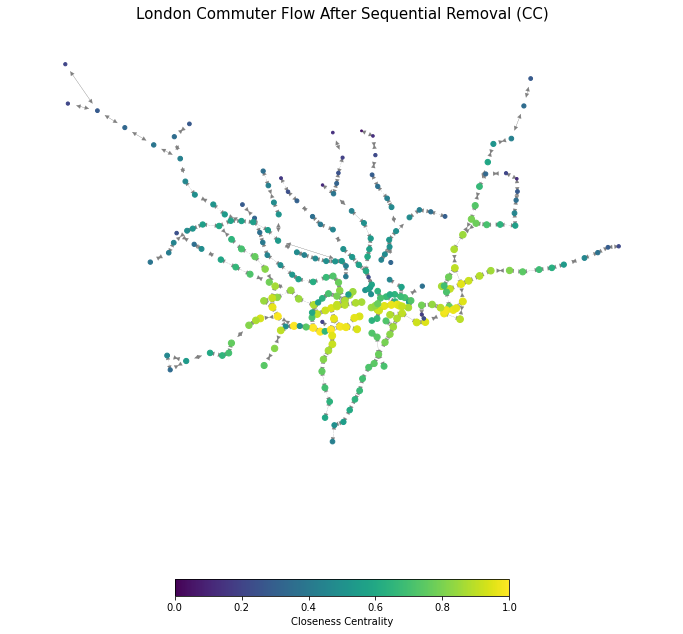

<Figure size 432x288 with 0 Axes>

In [37]:
# after removal plot
clos_w_val=[(i[1]['clos_flows']) for i in g_flows.nodes(data=True)]

clos_w_color=[(i[1]['clos_flows']/max(clos_w_val)) for i in g_flows.nodes(data=True)]
clos_w_size=[(i[1]['clos_flows']/max(clos_w_val)*50) for i in g_flows.nodes(data=True)]

pos={e1: xy for e1,xy in g_flows.nodes(data='station_coord')}

fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in g_shp_un.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(g_flows, pos,edge_color='gray', width=0.2)

nod=nx.draw_networkx_nodes(g_flows,
        pos = pos,
        node_color= clos_w_color,
        node_size= clos_w_size)

plt.axis("off")
plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London Commuter Flow After Sequential Removal (CC)",fontsize=15)

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('p2_CC2.png', dpi=100)

### Analysis

In [38]:
# 1. all connected components 
components = [len(c) for c in sorted(nx.strongly_connected_components(g_flows), key=len, reverse=True)]
len(components) # there are 36 strong components in the network

36

In [39]:
# 2. strongest component:
strong_component = max(nx.strongly_connected_components(g_flows), key=len)
G = g_flows.subgraph(strong_component)

In [40]:
print(nx.info(G))  # the largest connected component has 122 nodes remaining left

Name: 
Type: DiGraph
Number of nodes: 122
Number of edges: 258
Average in degree:   2.1148
Average out degree:   2.1148


In [41]:
# 3. unweighted diameter
nx.diameter(G)

40

In [42]:
# 4. weighted (distance) diameter
nlen = {n:nx.single_source_dijkstra_path_length(G, n, weight='clos_flows') 
        for n in G.nodes() }
e = nx.eccentricity(G,sp=nlen)
d = nx.diameter(G, e)
d

40

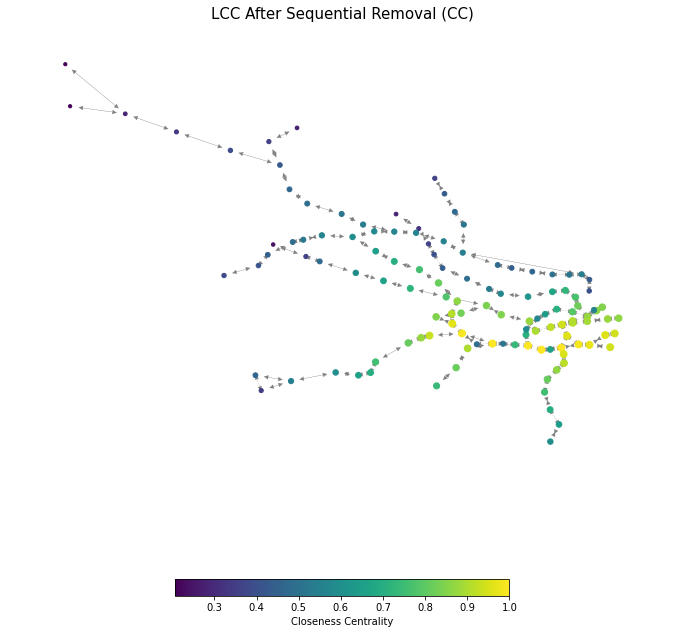

<Figure size 432x288 with 0 Axes>

In [43]:
# largest component plot
clos_w_val=[(i[1]['clos_flows']) for i in G.nodes(data=True)]

clos_w_color=[(i[1]['clos_flows']/max(clos_w_val)) for i in G.nodes(data=True)]
clos_w_size=[(i[1]['clos_flows']/max(clos_w_val)*50) for i in G.nodes(data=True)]

pos={e1: xy for e1,xy in G.nodes(data='station_coord')}

fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in G.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.2)

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= clos_w_color,
        node_size= clos_w_size)

plt.axis("off")
plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("LCC After Sequential Removal (CC)",fontsize=15)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('p2_CC3.png', dpi=100)